<a href="https://colab.research.google.com/github/brittdecker/Review/blob/master/Kalman_linreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kalman Filter Example


Example Goal: 

1) Create position vector over time

2) Add noise

3) run through the Kalman filter to predict next location

4) calculate the error of the fiter predictions

x̂N,N=1N(z1+z2+…+zN−1+zN)=1N∑n=1N(zn)

Notation:

xis the true value of the weight

zn is the measurement value of the weight at time n x̂n,

n is the estimate of x at time n (the estimate is made after taking the measurement zn)

x̂n,n−1 is the previous estimate of x that was made at time n−1 (the estimate was made after taking the measurement zn−1)

x̂n+1,n is the estimate of the future state (n+1) of x. The estimate is made at the time n, right after the measurement zn. In other words, xn+1,n is a predicted state


results
[0.1, 0.1, 0.09999999999999998, 0.10000000000000003, 0.09999999999999998, 0.09999999999999998, 0.09999999999999998, 0.10000000000000009, 0.09999999999999998, 0.09999999999999998, 0.10000000000000009, 0.09999999999999987, 0.10000000000000009, 0.09999999999999987, 0.10000000000000009, 0.10000000000000009, 0.09999999999999987, 0.10000000000000009, 0.09999999999999987, 0.10000000000000009, 0.10000000000000009, 0.10000000000000009, 0.09999999999999964, 0.10000000000000009, 0.10000000000000009, 0.10000000000000009, 0.10000000000000009, 0.09999999999999964, 0.10000000000000009, 0.10000000000000009, 0.10000000000000009, 0.10000000000000009, 0.09999999999999964, 0.10000000000000009, 0.10000000000000009, 0.10000000000000009, 0.10000000000000009, 0.09999999999999964, 0.10000000000000009, 0.10000000000000009, 0.09999999999999964, 0.10000000000000053, 0.09999999999999964, 0.10000000000000053, 0.09999999999999964, 0.09999999999999964, 0.10000000000000053, 0.09999999999999964, 0.1000000000000

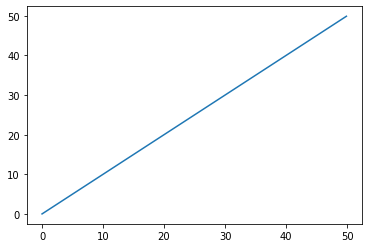

In [5]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import math
from scipy.stats import rv_discrete


def generate_positions(t,x,y,x_v,y_v,step):

  coord = {}
  coord['x'] = []
  coord['y'] = []
  coord['time'] = []
  coord['xvel'] = []
  coord['yvel'] = []

  for second in range(t):
    #Circle, ellipse, figure 8 trajectories TODO
    dt = round((second * step),4)
    #theta = round(((x_v * dt) + x),4)
    #thetax = (x_v * dt) + x
    #thetay = (y_v * dt) + y
    #Circle
    #yval = 1.0 * math.sin(theta)
    #xval = 1.0 * math.cos(theta)
    #Ellipse
    #thetax = 1 (rad/sec), thetay = 1.1 (rad/sec)
    #yval = 1.0 * math.sin(thetay)
    #xval = 1.0 * math.cos(thetax)
    #Line
    yval = (y_v * dt) + y
    xval = (x_v * dt) + x

    #dtheta/dt --> radial velocity
    #y = r/sin(theta), theta = (vel * time) + init
    if dt > 0.0:
      coord['xvel'].append((xval - coord['x'][-1]))
      #print("currentmeas: ", xval, "minus prevmeas ", coord['x'][-1])
      coord['yvel'].append((xval - coord['y'][-1]))
    coord['x'].append(xval)
    coord['y'].append(yval)
    coord['time'].append(dt)


  return coord

total_time = 500
bounds = total_time - 1

#for x, y at (0, 0), generate truth positions for 10 sec worth data for vel = 1 m/s
coordinates = generate_positions(total_time,0.0,0.0,1.0,1.0,0.1)  
print("results")
print(coordinates['xvel'])
print(coordinates['x'])
print(coordinates['yvel'])
print(coordinates['time'])

#plt.plot(coordinates['time'][100:bounds],coordinates['yvel'][100:bounds])
#plt.plot(coordinates['time'][100:bounds],coordinates['xvel'][100:bounds])

plt.plot(coordinates['x'],coordinates['y'])



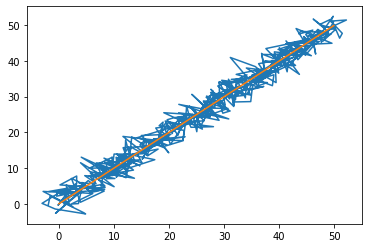

In [7]:
def measure(data, noise, time):
  AWGN = stats.norm(0, 1)
  noise = 2.0 * AWGN.rvs()
  #noise = 0

  sample = data[time] + noise

  return sample

x_sampled = []
y_sampled = []

for step in range(len(coordinates['time'])):
  x_sampled.append(measure(coordinates['x'],0,step))
  y_sampled.append(measure(coordinates['y'],0,step))

plt.plot(x_sampled,y_sampled)

plt.plot(coordinates['x'],coordinates['y'])




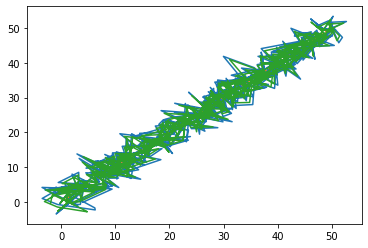

In [8]:
initial_state = [coordinates['x'][0],coordinates['y'][0]]

def meas_vel(delta_time, pos, prev_pos):

  vel = (pos - prev_pos)/delta_time

  return vel

def delta_t(time, prev_time):

  dt = time - prev_time

  return dt

def alphabeta_filter(delta_time, pos_meas, vel_meas, pos_pred, vel_pred):

  alpha = 0.2
  beta = 0.1

  next_pos = pos_pred + alpha*(pos_meas - pos_pred)

  next_vel = vel_pred + beta*((vel_meas - vel_pred)/delta_time)

  next_pos = next_pos + delta_time*next_vel

  return next_pos, next_vel

x_pred = {}
y_pred = {}
x_pred['pos'] = []
y_pred['pos'] = []
x_pred['vel'] = []
y_pred['vel'] = []

x_pred['vel'].append(meas_vel(coordinates['time'][1],coordinates['x'][1],coordinates['x'][0]))
y_pred['vel'].append(meas_vel(coordinates['time'][1],coordinates['y'][1],coordinates['y'][0]))

#Initialize filter
#For init, use meas = true, and sampled - true for pred
xvel_meas = meas_vel(coordinates['time'][1],coordinates['x'][1],coordinates['x'][0])
yvel_meas = meas_vel(coordinates['time'][1],coordinates['y'][1],coordinates['y'][0])
xpos, xvel = alphabeta_filter(coordinates['time'][1],coordinates['x'][0], xvel_meas, x_sampled[1], x_pred['vel'][0])
ypos, yvel = alphabeta_filter(coordinates['time'][1],coordinates['y'][0], yvel_meas, y_sampled[1], y_pred['vel'][0])
x_pred['pos'].append(xpos)
x_pred['vel'].append(xvel)
y_pred['pos'].append(ypos)
y_pred['vel'].append(yvel)



for i in range(1, len(x_sampled)):
  dt = delta_t(coordinates['time'][i],coordinates['time'][i-1])

  xvel_meas = meas_vel(dt,x_sampled[i],x_sampled[i-1])
  yvel_meas = meas_vel(dt,y_sampled[i],y_sampled[i-1])

  xpos, xvel = alphabeta_filter(dt,x_sampled[i], xvel_meas, x_pred['pos'][i-1], x_pred['vel'][i-1])
  ypos, yvel = alphabeta_filter(dt,y_sampled[i], yvel_meas, y_pred['pos'][i-1], y_pred['vel'][i-1])

  x_pred['pos'].append(xpos)
  x_pred['vel'].append(xvel)
  y_pred['pos'].append(ypos)
  y_pred['vel'].append(yvel)
  

#for i in range(len(x_sampled)):
  #print(i,x_sampled[i],x_pred['pos'][i],coordinates['x'][i])

#filter output
plt.plot(x_pred['pos'],y_pred['pos'], '-')
#ground truth
plt.plot(coordinates['x'],coordinates['y'], ':')
#noisy measurements
plt.plot(x_sampled,y_sampled, '-')

#plt.plot(coordinates['time'][:bounds],y_pred['vel'][:bounds])

var_avg = 0


# quantify filter performance (min MSE TODO)
#for sample in range(len(x_sampled)):
  #delta = (x_pred['pos'][sample] - coordinates['x'][sample])
  #var = (delta ** 2) / len(x_sampled)
  #var_avg += var





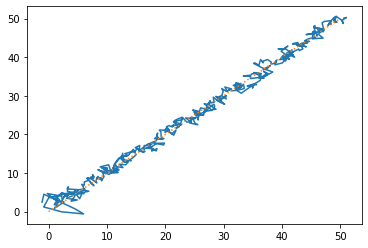

In [10]:
def kalman_filter(delta_time, pos_meas, vel_meas, pos_pred, vel_pred, est_uncertainty):

  #This is the measurement error, the standard deviation. 
  meas_uncertainty = 1.0
  #This is the term 'q'. It represents process noise. Low value = high certainty of the process
  process_uncertainty = 0.0009

  Kgain = est_uncertainty/(est_uncertainty + meas_uncertainty)

  next_pos = pos_pred + Kgain*(pos_meas - pos_pred)

  next_vel = vel_pred + Kgain*((vel_meas - vel_pred)/delta_time)

  next_pos = next_pos + delta_time*next_vel

  next_error = (1 - Kgain)*est_uncertainty + process_uncertainty


  return next_pos, next_vel, next_error

x_pred = {}
y_pred = {}
x_pred['pos'] = []
y_pred['pos'] = []
x_pred['vel'] = []
y_pred['vel'] = []
xerrorvals = []
yerrorvals = []


xerrorvals.append(.1)
yerrorvals.append(.1)

#Initialize filter
#For init, use meas = true, and sampled - true for pred
#Measured velocity is always using truth measurements
#On initialization, predicted values are replaced with the first guess
dt = delta_t(coordinates['time'][1],coordinates['time'][0])
xpos, xvel, xerror = kalman_filter(dt, x_sampled[0], 5.0, x_sampled[1], 5.0, xerrorvals[0])
ypos, yvel, yerror = kalman_filter(dt, y_sampled[0], 5.0, y_sampled[1], 5.0, yerrorvals[0])
x_pred['pos'].append(xpos)
x_pred['vel'].append(xvel)
y_pred['pos'].append(ypos)
y_pred['vel'].append(yvel)
xerrorvals.append(xerror)
yerrorvals.append(yerror)

xvel_m = []

#kalman params - delta_time, pos_meas, vel_meas, pos_pred, vel_pred, error
for i in range(1, len(x_sampled)):
  dt = round(delta_t(coordinates['time'][i],coordinates['time'][i-1]),2)

  xvel_meas = meas_vel(dt,x_sampled[i],x_sampled[i-1])
  yvel_meas = meas_vel(dt,y_sampled[i],y_sampled[i-1])

  xvel_m.append(xvel_meas)


  xpos, xvel, xerror = kalman_filter(dt,x_sampled[i], xvel_meas, x_pred['pos'][i-1], x_pred['vel'][i-1], xerrorvals[i])
  ypos, yvel, yerror = kalman_filter(dt,y_sampled[i], yvel_meas, y_pred['pos'][i-1], y_pred['vel'][i-1], yerrorvals[i])

  x_pred['pos'].append(xpos)
  x_pred['vel'].append(xvel)
  y_pred['pos'].append(ypos)
  y_pred['vel'].append(yvel)
  xerrorvals.append(xerror)
  yerrorvals.append(yerror)
  

#for i in range(len(x_sampled)):
  #print(i,x_sampled[i],x_pred['pos'][i],coordinates['x'][i])

#filter output
plt.plot(x_pred['pos'],y_pred['pos'], '-')
#ground truth
plt.plot(coordinates['x'],coordinates['y'], ':')
#noisy measurements
#plt.plot(x_sampled,y_sampled, ':')









y-intercept:  0.0
slope:  1.0
y-intercept:  -0.04803731404596639
slope:  1.0016873556379242
y-intercept:  0.238422688539625
slope:  0.9960403972667538


(0.238422688539625, 0.9960403972667538)

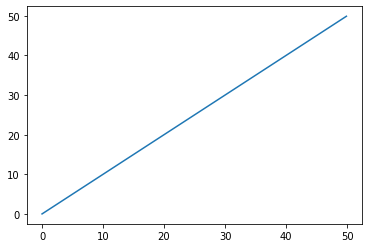

In [18]:
def lin_reg(x, y):
  sum_x2 = 0
  sum_x = 0
  sum_y2 = 0
  sum_y = 0
  sum_xy = 0
  
  #find x^2
  for each in x:
    sum_x2 += each ** 2
    sum_x += each

  #find y^2
  for each in y:
    sum_y2 += each ** 2
    sum_y += each
  
  #find xy
  for i in range(0, len(x)):
    sum_xy += (x[i] * y[i])

  a = (((sum_y) * (sum_x2)) - ((sum_x) * (sum_xy))) / ((len(x) * sum_x2) - ((sum_x) ** 2))

  b = ((len(x) * sum_xy) - (sum_x * sum_y)) / ((len(x) * sum_x2) - ((sum_x) ** 2))
  
  print("y-intercept: ", a)
  print("slope: ", b)

  return a, b

plt.plot(coordinates['time'],coordinates['x'])

lin_reg(coordinates['time'],coordinates['x'])
lin_reg(coordinates['time'],x_sampled)
lin_reg(coordinates['time'],x_pred['pos'])


In [ ]:
def CRLB():


  return CRLBest